<a href="https://colab.research.google.com/github/sborah53/Machine-Learning-for-Physical-Sciences/blob/main/MLPS_Decision_Tree_Ising_Model_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theory

**This notebook was created by Sangkha Borah, IIT Hyderabad**


## Physics: 2D Ising phases and observables
For a 2D Ising model with spins $s_i \in \{-1,+1\}$ on a lattice, the standard Hamiltonian (no field) is  
$$
H(\{s_i\}) = -J \sum_{\langle i,j\rangle} s_i s_j
$$
with $J>0$ for a ferromagnet. The magnetization and energy per spin are  
$$
m = \frac{1}{N}\sum_i s_i,\quad e = \frac{H}{N}.
$$
At temperature $T$, the Gibbs distribution is  
$$
P(\{s_i\}) = \frac{1}{Z(\beta)} e^{-\beta H(\{s_i\})},\quad \beta = \frac{1}{k_B T}.
$$
For $T<T_c$ (ferromagnetic phase), the equilibrium distribution is biased towards configurations with $|m|\approx {O}(1)$ and more negative $e$; for $T>T_c$ (paramagnetic phase), symmetry is restored and $|m|$ is small, with higher $e$ on average. A supervised classifier in the $(|m|, e)$ plane is effectively learning a coarse-grained phase boundary.

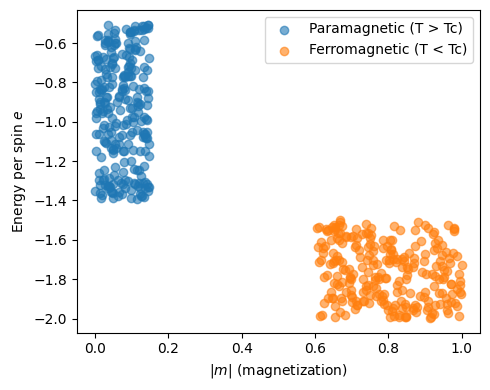

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Physics-like synthetic data ----------
np.random.seed(42)
n_samples = 500

# Paramagnetic (T > Tc): |m| ~ small, energy less negative
m_para = np.random.uniform(0.0, 0.15, n_samples // 2)
e_para = np.random.uniform(-1.4, -0.5, n_samples // 2)
y_para = np.zeros(n_samples // 2, dtype=int)   # class 0

# Ferromagnetic (T < Tc): |m| ~ large, energy more negative
m_ferro = np.random.uniform(0.6, 1.0, n_samples // 2)
e_ferro = np.random.uniform(-2.0, -1.5, n_samples // 2)
y_ferro = np.ones(n_samples // 2, dtype=int)  # class 1

X = np.column_stack((np.concatenate([m_para, m_ferro]),
                     np.concatenate([e_para, e_ferro])))
y = np.concatenate([y_para, y_ferro])

# ---------- Plot: phase-space scatter ----------
plt.figure(figsize=(5,4))
plt.scatter(m_para, e_para, c='tab:blue', alpha=0.6, label='Paramagnetic (T > Tc)')
plt.scatter(m_ferro, e_ferro, c='tab:orange', alpha=0.6, label='Ferromagnetic (T < Tc)')
plt.xlabel(r'$|m|$ (magnetization)')
plt.ylabel(r'Energy per spin $e$')
plt.legend()
plt.tight_layout()
plt.show()


This plot is your “physics section” visual: the phase-space separation in $(|m|,e)$.

## Scikit-learn decision tree
`DecisionTreeClassifier(criterion='entropy')` uses the same entropy and information gain as above, but with additional engineering: feature subsampling, optimized splitting, pruning options, and C-optimized code. Conceptually, it chooses at each node the split $(j,\theta)$ that maximizes  
$$
\Delta H = H(y) - \left(\frac{n_L}{n} H(y_L) + \frac{n_R}{n} H(y_R)\right),
$$
subject to constraints like `max_depth`, `min_samples_split`, etc., so it is mathematically equivalent to your custom implementation modulo details like handling of continuous thresholds and tie-breaking.



Scikit-learn tree accuracy: 1.0000


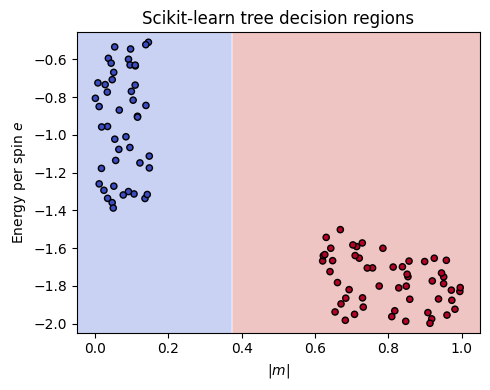

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scikit-learn decision tree (entropy criterion)
sklearn_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    random_state=42
)
sklearn_clf.fit(X_train, y_train)

y_pred_sklearn = sklearn_clf.predict(X_test)
print(f"Scikit-learn tree accuracy: {accuracy_score(y_test, y_pred_sklearn):.4f}")

# Decision regions
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min()-0.05, X[:, 0].max()+0.05, 200),
    np.linspace(X[:, 1].min()-0.05, X[:, 1].max()+0.05, 200),
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z_sklearn = sklearn_clf.predict(grid).reshape(xx.shape)

plt.figure(figsize=(5,4))
plt.contourf(xx, yy, Z_sklearn, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm',
            edgecolor='k', s=20)
plt.xlabel(r'$|m|$')
plt.ylabel(r'Energy per spin $e$')
plt.title('Scikit-learn tree decision regions')
plt.tight_layout()
plt.show()


## Custom decision tree (from scratch)

The custom tree implements exactly the same objective as above: minimize the Shannon entropy of class labels at each split, i.e. maximize $\Delta H$. You compute the parent entropy $H(y)$, then for every candidate feature $j$ and threshold $\theta$ you compute the weighted child entropy and pick the best $\theta$. Mathematically this is equivalent to scikit-learn’s ID3-style "entropy" criterion, just written in pure Python.

Custom tree accuracy: 0.9800


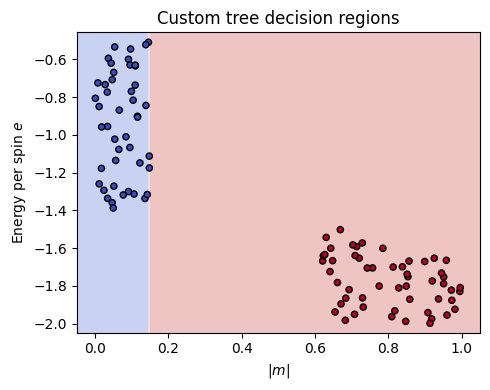

In [3]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        # Index of the feature used for splitting at this node (j in x_j).
        # If this is a leaf, feature is None.
        self.feature = feature

        # Threshold t used for splitting on feature j.
        # Split rule: go left if x_j ≤ t, go right if x_j > t.
        self.threshold = threshold

        # Left and right child nodes in the tree.
        self.left = left
        self.right = right

        # Class label stored at a leaf node (majority class in that region).
        # For internal nodes, value is None.
        self.value = value


    def is_leaf_node(self):
        # A node is a leaf if it stores a class label (value is not None).
        return self.value is not None


class DecisionTree:
        def __init__(self, max_depth=100, min_samples_split=2):
            # Maximum depth of the tree (controls model complexity).
            self.max_depth = max_depth

            # Minimum number of samples required to further split a node.
            self.min_samples_split = min_samples_split

            # Root node of the trained tree.
            self.root = None


        def fit(self, X, y):
            """
            Build the decision tree from training data (X, y).

            X ∈ ℝ^{N×d}: N samples, d features.
            y ∈ {0,1,…,C−1}^N: class labels.
            """
            self.root = self._grow_tree(X, y)


        def _grow_tree(self, X, y, depth=0):
            """
            Recursively grow the tree.

            Stopping criteria:
            1. depth ≥ max_depth
            2. all labels are identical (pure node)
            3. number of samples < min_samples_split
            """
            n_samples, n_features = X.shape
            # Number of distinct class labels in this node.
            n_labels = len(np.unique(y))

            # Stopping condition: make this node a leaf and store the majority class.
            if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
                # Majority class: arg max_k count(y_i = k).
                leaf_value = self._most_common_label(y)
                return Node(value=leaf_value)

            # Find the best feature index j* and threshold t* that maximize information gain.
            best_feat, best_thresh = self._best_criteria(X, y, n_features)

            # If no valid split is found, also create a leaf node.
            if best_feat is None:
                return Node(value=self._most_common_label(y))

            # Split the data based on the best feature and threshold:
            # Left: {i | X_i,feat ≤ t}, Right: {i | X_i,feat > t}.
            left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)

            # Recursively grow left and right subtrees, increasing depth by 1.
            left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
            right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

            # Return an internal node storing the split rule.
            return Node(best_feat, best_thresh, left, right)


        def _best_criteria(self, X, y, n_features):
            """
            Exhaustive search over:
            - all features j = 0,…,d−1
            - all unique values in that feature as candidate thresholds t

            For each candidate (j, t), compute information gain:
            IG(j,t) = H(parent) − [ (n_L/n) H(left) + (n_R/n) H(right) ].
            """
            best_gain = -1.0
            split_idx, split_thresh = None, None

            # Loop over all features j.
            for feat_idx in range(n_features):
                X_column = X[:, feat_idx]

                # Candidate thresholds are the unique feature values in this column.
                thresholds = np.unique(X_column)

                # Try each possible threshold t.
                for threshold in thresholds:
                    gain = self._information_gain(y, X_column, threshold)

                    # Keep the split that yields the maximum information gain.
                    if gain > best_gain:
                        best_gain = gain
                        split_idx = feat_idx
                        split_thresh = threshold

            return split_idx, split_thresh


        def _information_gain(self, y, X_column, threshold):
            """
            Compute information gain for splitting y according to:
            X_column ≤ threshold vs X_column > threshold.

            Let:
            - S be the set of indices in this node, |S| = n.
            - S_L = {i ∈ S | X_i ≤ t}, S_R = {i ∈ S | X_i > t}.
            - n_L = |S_L|, n_R = |S_R|.

            Entropy of labels in set S:
                H(S) = − ∑_k p_k log₂ p_k,
            where p_k = (# of samples in S with label k) / |S|.

            Information gain:
                IG = H(S) − [ (n_L/n) H(S_L) + (n_R/n) H(S_R) ].
            """
            # Entropy of the current node (parent).
            parent_entropy = self._entropy(y)

            # Partition indices into left and right subsets based on threshold.
            left_idxs, right_idxs = self._split(X_column, threshold)

            # If one side is empty, this split is useless; return zero gain.
            if len(left_idxs) == 0 or len(right_idxs) == 0:
                return 0.0

            # Sizes of parent and child sets.
            n = len(y)
            n_l, n_r = len(left_idxs), len(right_idxs)

            # Entropies of left and right children.
            e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])

            # Weighted average of child entropies:
            # H_children = (n_L/n) H(S_L) + (n_R/n) H(S_R).
            child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

            # Information gain = H(parent) − H_children.
            return parent_entropy - child_entropy


        def _split(self, X_column, split_thresh):
            """
            Given a 1D feature column X_column and threshold t:

            Left indices:
                left_idxs  = {i | X_column[i] ≤ t}
            Right indices:
                right_idxs = {i | X_column[i] > t}
            """
            left_idxs = np.argwhere(X_column <= split_thresh).flatten()
            right_idxs = np.argwhere(X_column > split_thresh).flatten()
            return left_idxs, right_idxs


        def _entropy(self, y):
            """
            Compute the Shannon entropy of the label array y.

            Let y contain labels in {0,1,…,C−1}.
            For each class k:
                count_k = # {i | y_i = k}
                p_k = count_k / N,  where N = len(y).

            Entropy:
                H(y) = − ∑_k p_k log₂ p_k   (only for p_k > 0).
            """
            # hist[k] = count of label k.
            hist = np.bincount(y)

            # Convert counts to probabilities p_k.
            ps = hist / len(y)

            # Compute −∑ p_k log₂ p_k over nonzero probabilities.
            return -np.sum([p * np.log2(p) for p in ps if p > 0])


        def _most_common_label(self, y):
            """
            Return the majority class in y:
                arg max_k count(y_i = k).
            """
            counter = Counter(y)
            return counter.most_common(1)[0][0]


        def predict(self, X):
            """
            Predict class labels for all samples in X.

            For each sample x, traverse the tree from the root using
            the learned decision rules until reaching a leaf.
            """
            return np.array([self._traverse_tree(x, self.root) for x in X])


        def _traverse_tree(self, x, node):
            """
            Recursively traverse the tree for a single sample x.

            At an internal node with feature index j and threshold t:
                if x_j ≤ t: go to left child
                else:       go to right child

            At a leaf node, return the stored class label.
            """
            if node.is_leaf_node():
                # Leaf: output stored class label.
                return node.value

            # Internal node: choose branch based on split rule.
            if x[node.feature] <= node.threshold:
                return self._traverse_tree(x, node.left)
            return self._traverse_tree(x, node.right)


# Train and evaluate
# Here, X_train ∈ ℝ^{N_train×2} could be (|m|, e) for the Ising model,
# and y_train are phase labels (e.g., ordered vs disordered).
custom_clf = DecisionTree(max_depth=5)
custom_clf.fit(X_train, y_train)

# Predict labels on test set and compute accuracy:
# accuracy = (# correct predictions) / (# total test samples).
y_pred_custom = custom_clf.predict(X_test)
print(f"Custom tree accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")


# Decision regions
# Evaluate the classifier on a dense grid in (|m|, e) space to visualize
# the partition of feature space into different predicted phases.
Z_custom = custom_clf.predict(grid).reshape(xx.shape)

plt.figure(figsize=(5,4))
# Contour plot of predicted labels over the grid (decision regions).
plt.contourf(xx, yy, Z_custom, alpha=0.3, cmap='coolwarm')

# Scatter plot of test data, colored by true label y_test.
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm',
            edgecolor='k', s=20)

# Here X_test[:, 0] ≈ |m| (absolute magnetization), X_test[:, 1] ≈ e (energy per spin).
plt.xlabel(r'$|m|$')
plt.ylabel(r'Energy per spin $e$')
plt.title('Custom tree decision regions')
plt.tight_layout()
plt.show()
